In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.utilities.video_util import pil_frames_to_clip
import wandb_util.wandb_util as wbu
from text3d2video.utilities.ipython_utils import display_ims
import torchvision.transforms.functional as TF

torch.set_grad_enabled(False)

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.video_artifact import VideoArtifact
from omegaconf import OmegaConf

# deadpool cat
# video_tag = "video:v855" # Deadpool catwalk 180
video_tag = "video:v897" # Deadpool Cat

video = VideoArtifact.from_wandb_artifact_tag(video_tag)
frames = video.read_frames()

# recover animation
gr_run = video.logged_by()
anim = wbu.used_artifacts(gr_run, type="animation")[0]
anim = AnimationArtifact.from_wandb_artifact(anim)
cameras, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()

# recover prompt
prompt = OmegaConf.create(gr_run.config).prompt

In [3]:
from text3d2video.rendering import render_depth_map, render_rgb_uv_map
from text3d2video.utilities.video_comparison import display_vids

depths = render_depth_map(meshes, cameras)

frames_vid = pil_frames_to_clip(frames)
uvs_vid = pil_frames_to_clip(render_rgb_uv_map(meshes, cameras, verts_uvs, faces_uvs))
depths_vid = pil_frames_to_clip(depths)

display_vids([frames_vid, depths_vid, uvs_vid], title=prompt)

In [5]:
from text3d2video.pipelines.method import TexturingPipeline
from text3d2video.pipelines.pipeline_utils import load_pipeline

pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

# Single sequential-inpainting denoising Step

In [398]:
t_index = 3
pipe.scheduler.set_timesteps(10)
t = pipe.scheduler.timesteps[t_index]
print(t)

latents_clean = pipe.encode_images(frames)
noise = torch.randn_like(latents_clean)
latents = pipe.scheduler.add_noise(latents_clean, noise, t)

tensor(601)


In [402]:
from torch import Tensor

indices = torch.arange(0, latents.shape[0], 1).long()

latents_sampled = latents[indices]
cameras_sampled = cameras[indices]
meshes_sampled = meshes[indices]

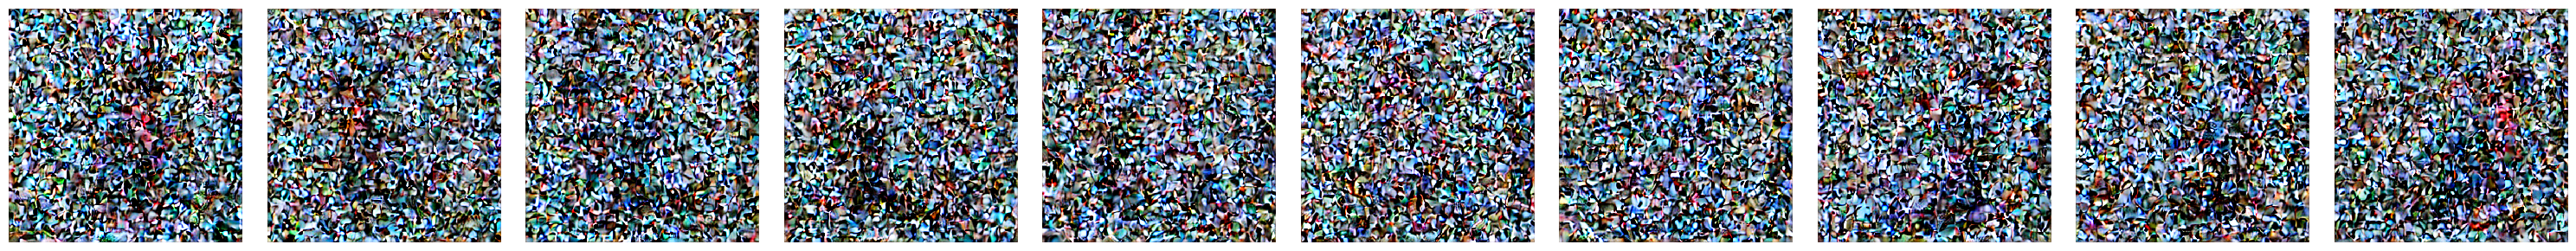

In [403]:

decoded_latents = pipe.decode_latents(latents_sampled)

display_ims(decoded_latents)

In [405]:
from text3d2video.pipelines.method import TexturingLogic
method = TexturingLogic(pipe)

In [406]:
from text3d2video.rendering import render_depth_map

depths = render_depth_map(meshes_sampled, cameras_sampled)
prompts = [prompt] * len(latents_sampled)
cond_embeddings, uncond_embeddings = pipe.encode_prompt(prompts)

In [407]:
pipe.scheduler.set_timesteps(10)

In [408]:
cam_seq = method.precompute_cam_seq(
    cameras_sampled, meshes_sampled, verts_uvs, faces_uvs
)

In [409]:
from pathlib import Path
from text3d2video.utilities.logging import H5Logger

logger = H5Logger(Path("data.h5"))
logger.delete_data()
logger.open_write()

texture = torch.zeros(600, 600, 3).cuda()

updated_latents, clean_tex = method.predict_clean_texture(
    latents, cond_embeddings, uncond_embeddings, t, texture, cam_seq, logger=logger
)

logger.close()
logger.open_read()

In [410]:
len(cam_seq.cameras)

10

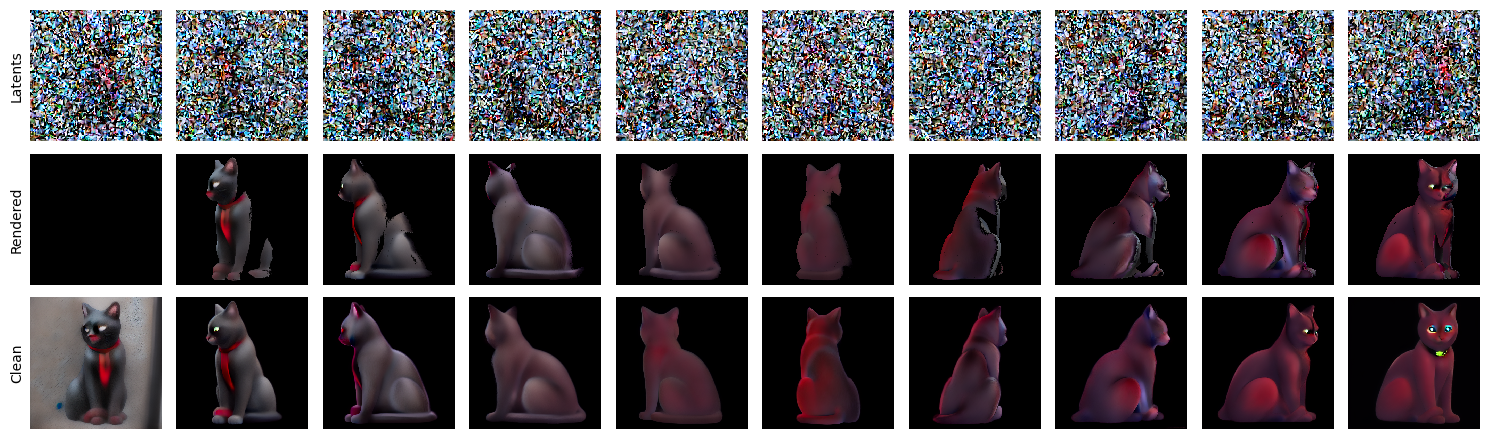

In [411]:
from text3d2video.utilities.ipython_utils import display_ims_grid
import matplotlib.pyplot as plt

ts = logger.key_values("clean_im", "t")
frame_indices = logger.key_values("clean_im", "frame_i")

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=ts[0], frame_i=i, transform=to_pil) for i in frame_indices
]

rendered = [
    logger.read("rendered", t=ts[0], frame_i=i, transform=to_pil) for i in frame_indices
]
fig, axs = display_ims_grid(
    [decoded_latents, rendered, clean_ims],
    row_titles=["Latents", "Rendered", "Clean"],
    scale=1.5,
    show=False,
)

plt.savefig("outs/figure.pdf", dpi=300)

In [507]:
# latents.shape


# Full Inference

In [508]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import add_title_to_clip
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool Cat"
uvs = render_rgb_uv_map(meshes, cameras, verts_uvs, faces_uvs)

vid = add_title_to_clip(pil_frames_to_clip(uvs), f'"{prompt}"')
display_vid(vid)

In [509]:
from text3d2video.pipelines.method import TexturingConfig


config = TexturingConfig(num_inference_steps=10)

indices = torch.arange(len(meshes)).long()

logger = H5Logger(Path("data.h5"), enabled=True)
logger.delete_data()
logger.open_write()

generator = torch.Generator(device="cuda").manual_seed(0)

images = pipe(
    prompt,
    meshes[indices],
    cameras[indices],
    verts_uvs,
    faces_uvs,
    config,
    logger=logger,
    generator=generator,
)

logger.close()
logger.open_read()

 10%|█         | 1/10 [00:03<00:30,  3.38s/it]

w_texture: 0.0, w_text: 7.5


 20%|██        | 2/10 [00:06<00:28,  3.52s/it]

w_texture: 0.0, w_text: 7.5


 30%|███       | 3/10 [00:10<00:24,  3.57s/it]

w_texture: 0.0, w_text: 7.5


 40%|████      | 4/10 [00:14<00:21,  3.60s/it]

w_texture: 0.0, w_text: 7.5


 50%|█████     | 5/10 [00:17<00:18,  3.62s/it]

w_texture: 0.0, w_text: 7.5


 60%|██████    | 6/10 [00:21<00:14,  3.64s/it]

w_texture: 0.0, w_text: 7.5


 70%|███████   | 7/10 [00:25<00:10,  3.65s/it]

w_texture: 0.0, w_text: 7.5


 80%|████████  | 8/10 [00:28<00:07,  3.65s/it]

w_texture: 0.0, w_text: 7.5


 90%|█████████ | 9/10 [00:32<00:03,  3.69s/it]

w_texture: 0.0, w_text: 7.5


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

w_texture: 0.0, w_text: 7.5


In [510]:
from text3d2video.rendering import render_texture


ts = sorted(logger.key_values("clean_tex", "t"), reverse=True)

clean_texs = [logger.read("clean_tex", t=t) for t in ts]
clean_texs = torch.stack(clean_texs)

tex = clean_texs[-1].cuda()

renders = render_texture(meshes, cameras, tex, verts_uvs, faces_uvs, return_pil=True)
display_vid(pil_frames_to_clip(renders))

1


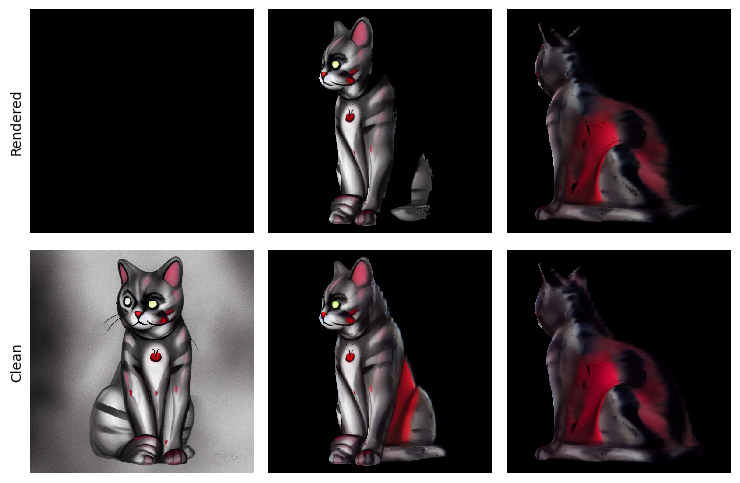

: 

In [511]:
from text3d2video.util import object_array


ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_indices = logger.key_values("clean_im", "frame_i")

t_vis = ts[9]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=i, transform=to_pil) for i in frame_indices
]

rendered = [
    logger.read("rendered", t=t_vis, frame_i=i, transform=to_pil) for i in frame_indices
]

grid = object_array([rendered, clean_ims])

fig, axs = display_ims_grid(
    grid[:, 0:3],
    row_titles=["Rendered", "Clean"],
    show=False,
)

# plt.savefig("outs/figure.pdf", dpi=300)


In [505]:
from text3d2video.util import object_array

vis_ts = ts
print(vis_ts)

ims_grid = []
for vis_t in vis_ts:
    images = [
        logger.read("clean_im", t=vis_t, frame_i=i, transform=to_pil)
        for i in frame_indices
    ]
    ims_grid.append(images)

ims_grid = object_array(ims_grid).T

[901, 801, 701, 601, 501, 401, 301, 201, 101, 1]


In [506]:
vids = [pil_frames_to_clip(ims) for ims in ims_grid.T]
display_vids(vids)